In [1]:
# Using processed_results.csv created in /circuits/f1_analysis.ipynb

In [28]:
import torch
import pickle
import einops
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.colors import Normalize

import circuits.analysis as analysis
import circuits.eval_sae_as_classifier as eval_sae
import circuits.chess_utils as chess_utils
import circuits.utils as utils

In [29]:
df = pd.read_csv('processed_results_group-2024-05-14-chess-v2.csv')
for col in df.columns:
    if 'fork' in col:
        print(col)

In [30]:
# Naming conventions Chess

# Reconstruction
reconstruction_all_col = 'best_f1_score_per_square_average'
reconstruction_basic_col = 'board_to_piece_state_best_f1_score_per_square'
reconstruction_8x8_col = 'best_f1_score_per_square_only_board_state_average'
reconstruction_1x1_col = 'best_f1_score_per_square_only_binary_average'
reconstruction_cols = [reconstruction_all_col, reconstruction_basic_col, reconstruction_8x8_col, reconstruction_1x1_col]
reconstruction_col_names = ['All reconstructions', 'Reconstruction of low-level BSP', '8x8 reconstructions', 'Reconstruction of high-level BSP']

# Coverage
coverage_all_col = 'best_custom_metric_average'
coverage_basic_col = 'board_to_piece_state_best_custom_metric'
coverage_8x8_col = 'best_custom_metric_only_board_state_average'
coverage_1x1_col = 'best_custom_metric_only_binary_average'
coverage_cols = [coverage_all_col, coverage_basic_col, coverage_8x8_col, coverage_1x1_col]
coverage_col_names = ['All coverages', 'Coverage of low-level BSP', '8x8 coverages', 'Coverage of high-level BSP']

In [1]:
# Naming conventions Othello

# # Reconstruction
# reconstruction_all_col = 'best_f1_score_per_square_average'
# reconstruction_basic_col = 'best_f1_score_per_square_only_binary_average'
# reconstruction_8x8_col = 'best_f1_score_per_square_only_board_state_average'
# reconstruction_1x1_col = 'best_f1_score_per_square_only_binary_average'
# reconstruction_cols = [reconstruction_all_col, reconstruction_basic_col, reconstruction_8x8_col, reconstruction_1x1_col]
# reconstruction_col_names = ['All reconstructions', 'Reconstruction of low-level BSP', '8x8 reconstructions', 'Reconstruction of high-level BSP']

# # Coverage
# coverage_all_col = 'best_custom_metric_average'
# coverage_basic_col = 'best_custom_metric_only_binary_average'
# coverage_8x8_col = 'best_custom_metric_only_board_state_average'
# coverage_1x1_col = None # Only low level BSP for othello!
# coverage_cols = [coverage_all_col, coverage_basic_col, coverage_8x8_col, coverage_1x1_col]
# coverage_col_names = ['All coverages', 'Coverage of low-level BSP', '8x8 coverages', 'Coverage of high-level BSP']

In [54]:
# get unique trainer types
unique_trainers = df['trainer_class'].unique()

# create a dictionary mapping trainer types to marker shapes
trainer_markers = dict(zip(unique_trainers, ['o', 's', '^', 'D']))

# names ['Gated SAE', 'Gated SAE w/ p-annealing', 'Standard', 'Standard w/ p-annealing']
#  create a dictionary mapping trainer types to names
trainer_names = dict(zip(unique_trainers, ['Gated SAE', 'Gated SAE w/ p-annealing', 'Standard w/ p-annealing', 'Standard']))



plt.rcParams.update({'font.size': 14})

def plot_custom_metric(color_column: str, color_column_name: str , ymin: float = 0.0, save: bool = False, cbar_scale_fixed: bool = False):
    # create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(zorder=0, alpha=0.5)


    metric_1 = "l0"
    metric_1_label = r'$L_0$ (Lower is sparser)'
    metric_2 = "frac_recovered"
    metric_2_label = 'Loss Recovered (Fidelity)'

    if cbar_scale_fixed:
        norm = Normalize(vmin=0.5, vmax=0.8)
    else:
        norm = Normalize(vmin=df[color_column][df[metric_2]>=ymin].min(), vmax=df[color_column][df[metric_2]>=ymin].max())

    # plot data points for each trainer type separately
    for trainer, marker in trainer_markers.items():
        trainer_data = df[df['trainer_class'].str.contains(trainer)]
        ax.scatter(trainer_data[metric_1], trainer_data[metric_2], c=trainer_data[color_column], cmap='viridis', marker=marker, s=80, label=trainer_names[trainer], norm=norm, zorder=3)

    # add colorbar
    cbar = fig.colorbar(ax.collections[0], ax=ax)
    cbar.set_label(color_column_name)

    # set labels and title
    ax.set_xlabel(metric_1_label)
    # ax.set_ylabel(f'1 - {metric_2_label}')
    ax.set_ylabel(metric_2_label)
    ax.set_title(f'{color_column_name} vs Standard Metrics')

    # addnd
    lg = ax.legend(title='Trainer Type', loc='lower right')
    lg.get_frame().set_alpha(1)

    # # set x range
    ax.set_xlim(0, 800)
    ax.set_ylim(0.997, 1.0002)
    # ax.set_yscale('log')
    
    # display the plot
    if save:
        plt.savefig(f'{color_column_name.lower().replace(" ", "_")}_vs_standard_metrics.png', dpi=200)
    plt.show()


def plot_L0_vs_metric(color_column: str, color_column_name: str , ymin: float = 0.0, save: bool = False, cbar_scale_fixed: bool = False):
    # create the scatter plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.grid(zorder=0, alpha=0.5)


    metric_1 = "l0"
    metric_1_label = r'$L_0$ (Lower is sparser)'
    metric_2 = "frac_recovered"
    metric_2_label = 'Loss Recovered (Fidelity)'

    # if cbar_scale_fixed:
    #     norm = Normalize(vmin=0.5, vmax=0.8)
    # else:
    #     norm = Normalize(vmin=df[color_column][df[metric_2]>=ymin].min(), vmax=df[color_column][df[metric_2]>=ymin].max())

    # plot data points for each trainer type separately
    for trainer, marker in trainer_markers.items():
        trainer_data = df[df['trainer_class'].str.contains(trainer)]
        ax.scatter(trainer_data[metric_1], trainer_data[color_column], marker=marker, s=80, label=trainer_names[trainer], zorder=3)

    # add colorbar
    # cbar = fig.colorbar(ax.collections[0], ax=ax)
    # cbar.set_label(color_column_name)

    # set labels and title
    ax.set_xlabel(metric_1_label)
    # ax.set_ylabel(f'1 - {metric_2_label}')
    ax.set_ylabel(color_column_name)
    ax.set_title(f'L_0 vs {color_column_name}')

    # addnd
    lg = ax.legend(title='Trainer Type', loc='lower right')
    # lg.get_frame().set_alpha(1)

    # # set x range
    ax.set_xlim(0, 700)
    # ax.set_ylim(ymin, 1.001)
    # ax.set_yscale('log')
    
    # display the plot
    if save:
        plt.savefig(f'{color_column_name.lower().replace(" ", "_")}_vs_standard_metrics.png', dpi=200)
    plt.show()

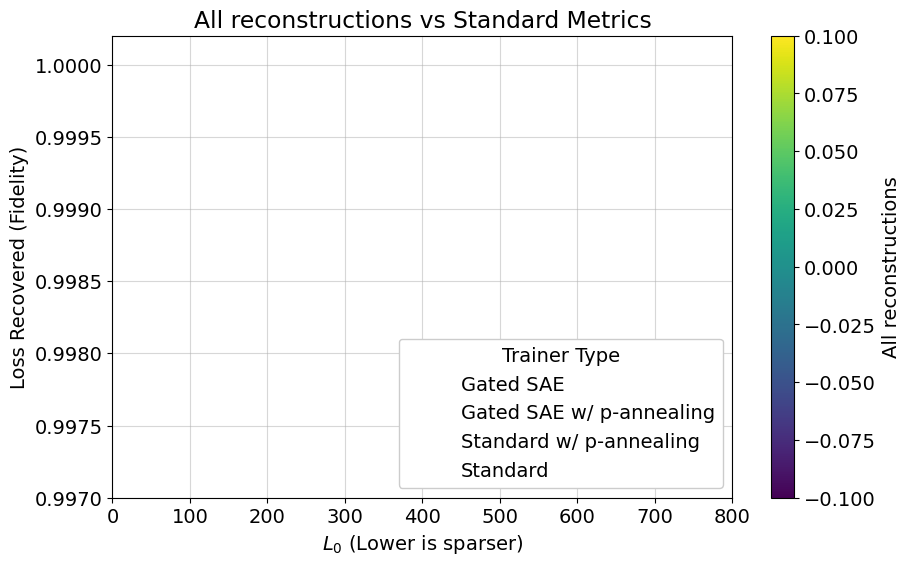

In [55]:
plot_custom_metric(reconstruction_all_col, 'All reconstructions', ymin=0.98)

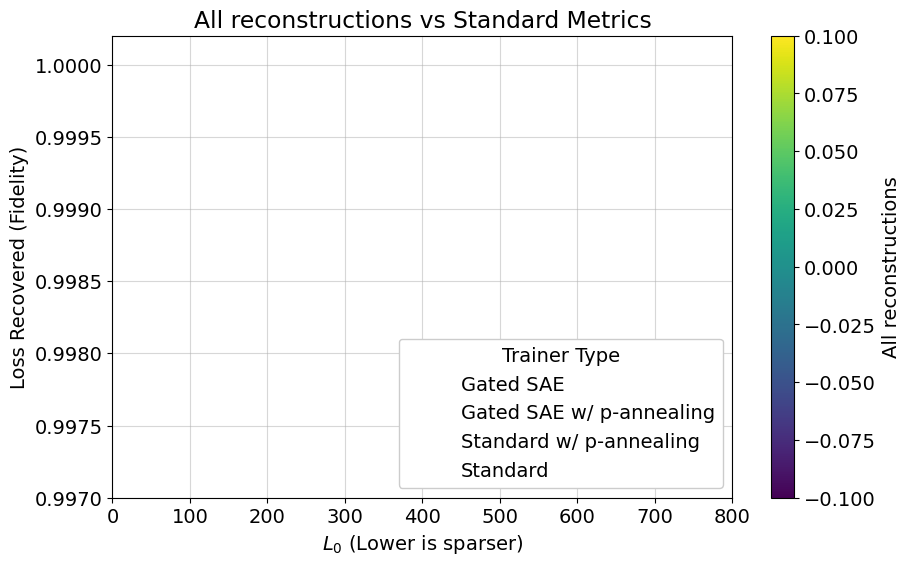

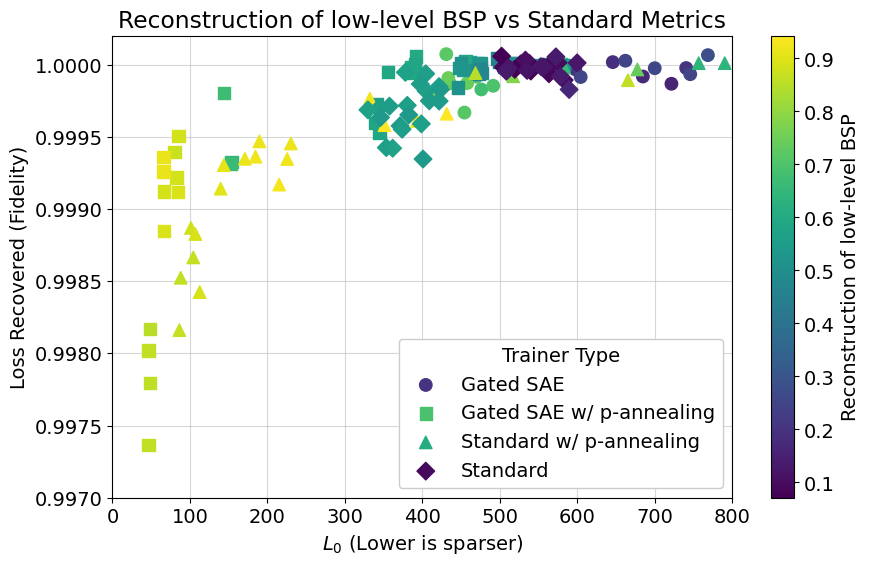

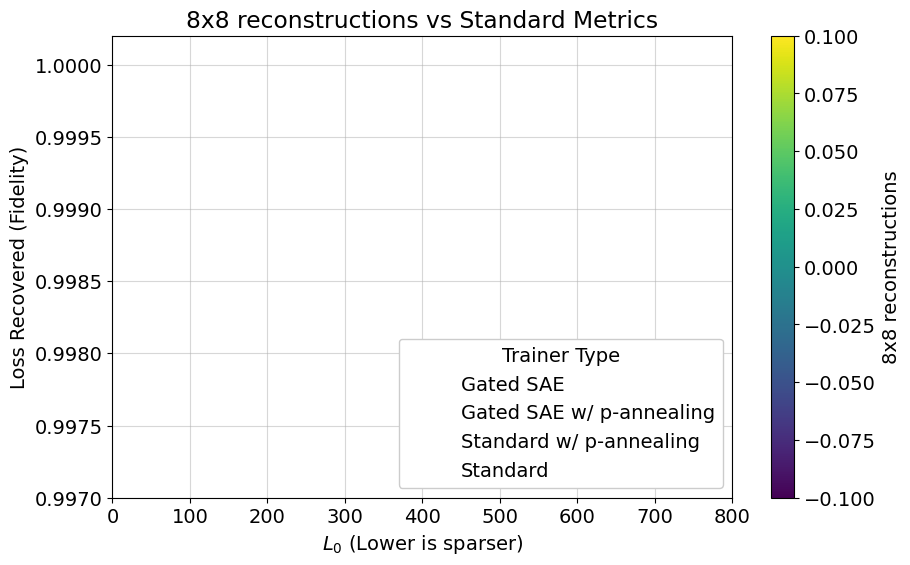

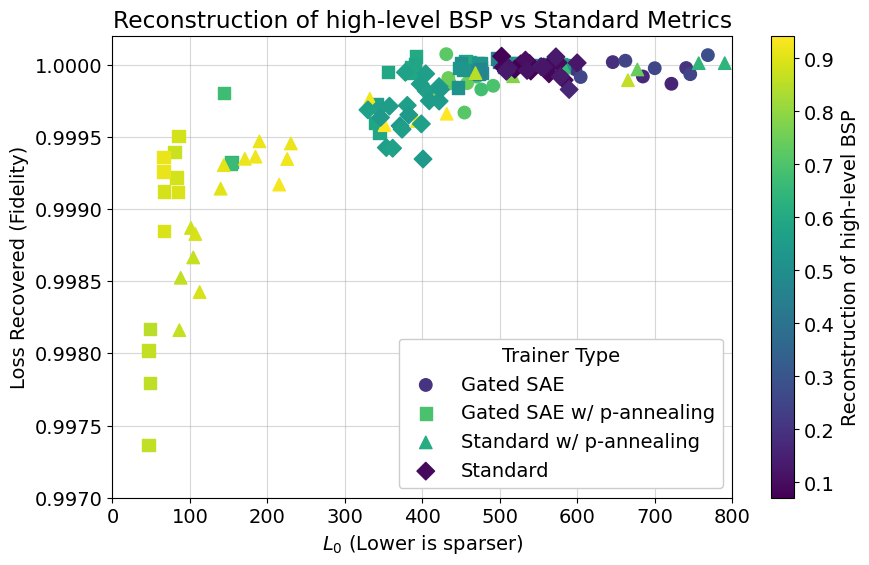

In [56]:
fix_cbar = False
set_ymin = 0.9825

for col, name in zip(reconstruction_cols, reconstruction_col_names):
    plot_custom_metric(col, name, ymin=set_ymin, save=False, cbar_scale_fixed=fix_cbar)

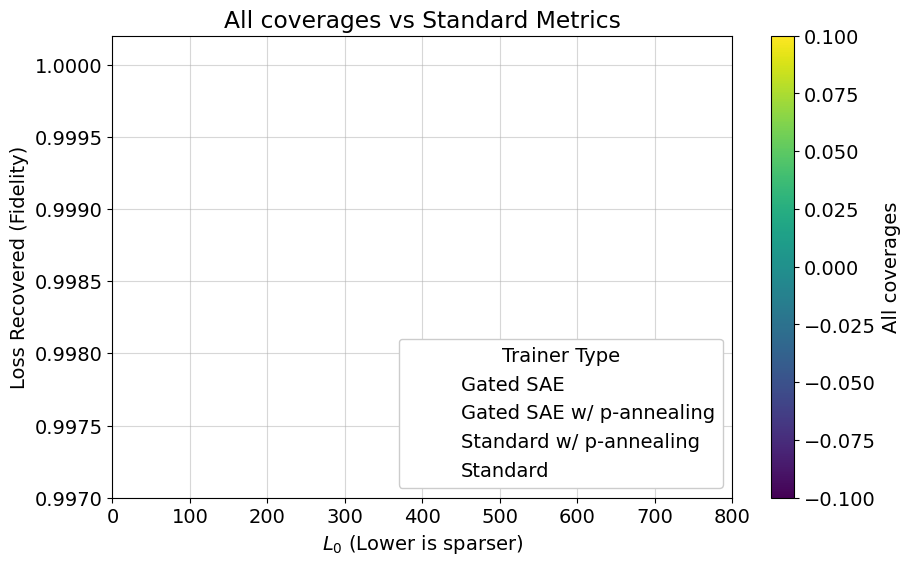

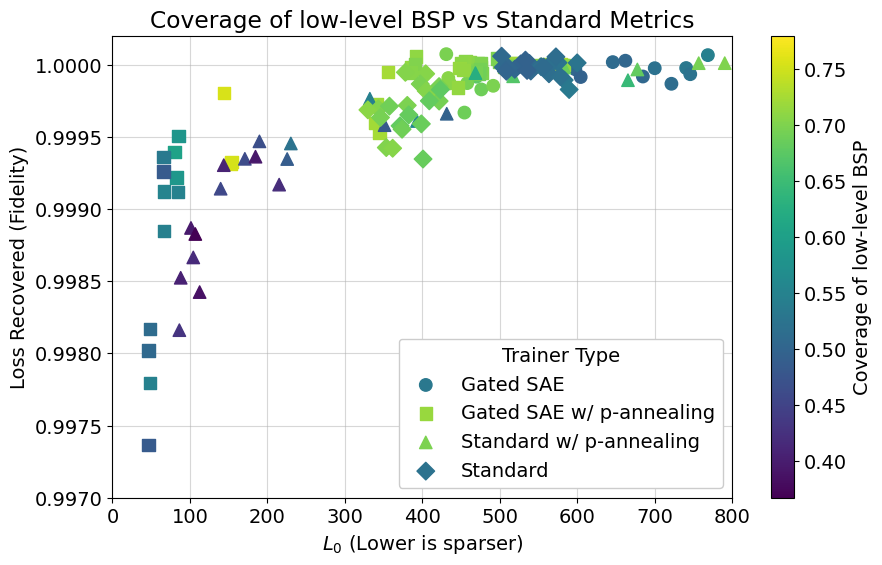

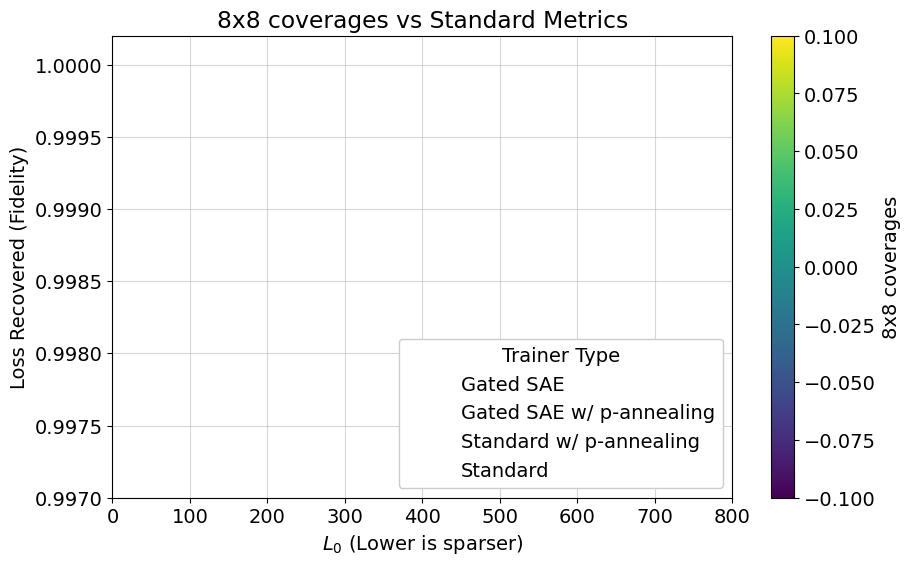

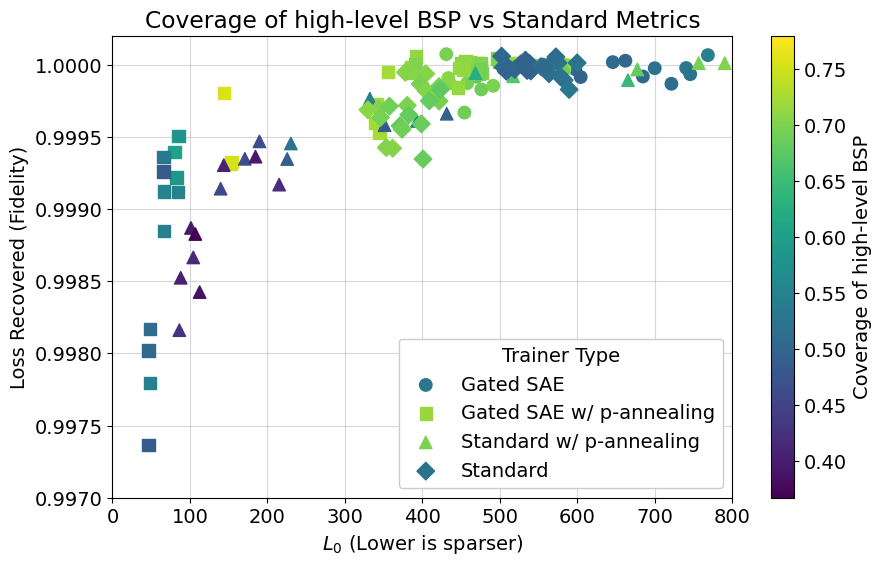

In [57]:
fix_cbar = False
set_ymin = 0.9825

for col, name in zip(coverage_cols, coverage_col_names):
    plot_custom_metric(col, name, ymin=set_ymin, save=False, cbar_scale_fixed=fix_cbar)

In [ ]:
(df['best_f1_score_per_square_only_board_state_average'] - df['best_f1_score_per_square_average']).sum()

0.0